# data

In [1]:
!pip install -q \
    transformers==4.10.3 \
    datasets==2.20.0 \
    pyarrow==15.0.0 \
    git+https://github.com/huggingface/peft.git \
    git+https://github.com/salaniz/pycocoevalcap \
    bitsandbytes \
    evaluate \
    sacrebleu \
    nltk \
    rouge-score \
    torch
!pip install --upgrade transformers
!pip install peft
!pip uninstall numpy -y
!pip install numpy --upgrade
!pip install sacrebleu nltk pycocoevalcap
!pip install pycocoevalcap


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━

  Using cached sacrebleu-2.5.1-py3-none-any.whl.metadata (51 kB)
  Using cached portalocker-3.2.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
Using cached sacrebleu-2.5.1-py3-none-any.whl (104 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.8 MB/s eta 0:00:00
Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Using cached portalocker-3.2.0-py3-none-any.whl (22 kB)
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main_parser.py", line 9, 

In [1]:
import os
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW

from transformers import (
    BlipProcessor,
    BlipForConditionalGeneration,
    get_scheduler,
    BitsAndBytesConfig
)

from peft import LoraConfig, get_peft_model

from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

import nltk
nltk.download('punkt')
from tqdm.auto import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:

# Create directories for your data
os.makedirs('/kaggle/working/datasets/train_ROCOv2', exist_ok=True)
os.makedirs('/kaggle/working/datasets/test_ROCOv2', exist_ok=True)

# Download the main ROCOV2 file
!wget -O /kaggle/working/ROCOV2.zip https://zenodo.org/api/records/10821435/files-archive
# Unzip the main ROCOV2 file
!unzip /kaggle/working/ROCOV2.zip -d /kaggle/working/

# Unzip the train images
!unzip /kaggle/working/train_images.zip -d /kaggle/working/datasets/train_ROCOv2/

# Unzip the test images
!unzip /kaggle/working/test_images.zip -d /kaggle/working/datasets/test_ROCOv2/

Streaming output truncated to the last 5000 lines.
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004946.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004947.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004948.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004949.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004950.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004951.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004952.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004953.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004954.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004955.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004956.jpg  
 extracting: /

# code

In [3]:
import transformers
print(transformers.__version__)


4.53.1


In [ ]:
drive_path = '/kaggle/working/'

train_images_path = os.path.join(drive_path, 'datasets/train_ROCOv2/')
test_images_path = os.path.join(drive_path, 'datasets/test_ROCOv2/')
train_csv_path = os.path.join(drive_path, 'train_captions.csv')
test_csv_path = os.path.join(drive_path, 'test_captions.csv')

df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

# Use only 10% of the training data
df_train = df_train.sample(frac=0.1, random_state=42).reset_index(drop=True)

class MergeImageAndCaption(Dataset):
    def __init__(self, dataset, phase='train'):
        self.dataset = dataset
        root = os.path.join(drive_path, f'datasets/{phase}_ROCOv2/{phase}')
        self.image_list = [os.path.join(root, f'{file_}.jpg') for file_ in dataset['ID'].tolist()]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        img = Image.open(image_path).convert("RGB")
        caption = self.dataset['Caption'][idx]
        return {"text": caption, "image": img}

dataset_train = MergeImageAndCaption(df_train, phase='train')
dataset_test = MergeImageAndCaption(df_test, phase='test')

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        if not isinstance(image, torch.Tensor):
            image = transform(image)  # Apply transformation if the image is not already a tensor
        encoding = self.processor(images=image, text=item["text"], return_tensors="pt", padding="max_length")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        return encoding

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


# Initialize model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Function to count total and trainable parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

# Apply LoRA with correct target modules
config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["attention.self.query", "attention.self.key"]  # Updated target modules
)
model = get_peft_model(model, config)
count_parameters(model)  # Print parameter counts

# Initialize optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataset_train) * 10  # Reduced number of epochs for quick training
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Function to generate captions for three test images before training
def generate_captions_for_test_images(model, dataset_test, processor, device):
    model.eval()
    test_dataloader = DataLoader(dataset_test, batch_size=3, shuffle=False, collate_fn=lambda x: collate_fn(x, processor))
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            if i == 0:  # Process only the first batch
                pixel_values = batch["pixel_values"].to(device)
                outputs = model.generate(pixel_values=pixel_values, num_beams=4, max_length=128, early_stopping=True)
                captions = processor.batch_decode(outputs, skip_special_tokens=True)
                print("Generated Captions for 3 Test Images Before Training:")
                for idx, caption in enumerate(captions):
                    print(f"Image {idx + 1}: {caption}")
                break

# generate_captions_for_test_images(model, dataset_test, processor, device)

# Function to check for out-of-vocabulary (OOV) words in the dataset
def check_oov_words(dataset, tokenizer):
    all_captions = " ".join(dataset['Caption'].tolist())
    words = all_captions.split()
    vocab = tokenizer.get_vocab().keys()
    oov_words = [word for word in words if word not in vocab]
    oov_word_counts = {word: words.count(word) for word in set(oov_words)}
    print(f"Number of OOV words: {len(oov_word_counts)}")
    print(f"OOV words and their counts: {oov_word_counts}")

# check_oov_words(df_train, processor.tokenizer)  # Check OOV words in training dataset

# Function to train the model for one epoch and save the loss
def train_one_epoch(model, train_dataloader, optimizer, lr_scheduler, device):
    model.train()
    total_loss = 0
    num_batches = len(train_dataloader)
    with tqdm(total=num_batches, desc="Training", unit="batch") as pbar:
        for batch_idx, batch in enumerate(train_dataloader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            pbar.update(1)
            pbar.set_postfix(loss=loss.item())

    average_loss = total_loss / num_batches
    return average_loss

# Paths for saving model and optimizer state
model_path = "/kaggle/working/blip-finetuned"
optimizer_state_path = os.path.join(model_path, "optimizer_state.pt")
scheduler_state_path = os.path.join(model_path, "scheduler_state.pt")

# Initialize data loaders
train_dataloader = DataLoader(ImageCaptioningDataset(dataset_train, processor), batch_size=3, shuffle=True)
test_dataloader = DataLoader(ImageCaptioningDataset(dataset_test, processor), batch_size=3, shuffle=True)

# Training loop
num_epochs = 6  # Reduced number of epochs for quick training
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_dataloader, optimizer, lr_scheduler, device)
    print(f"Average training loss: {train_loss}")

    # Save the model and optimizer state
    model.save_pretrained(model_path)
    torch.save(optimizer.state_dict(), optimizer_state_path)
    torch.save(lr_scheduler.state_dict(), scheduler_state_path)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Total parameters: 247708988
Trainable parameters: 294912
Epoch 1/6


Training:   0%|          | 0/1999 [00:00<?, ?batch/s]

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Average training loss: 9.629889463889354
Epoch 2/6


Training:   0%|          | 0/1999 [00:00<?, ?batch/s]

Average training loss: 8.776850411747622
Epoch 3/6


Training:   0%|          | 0/1999 [00:00<?, ?batch/s]

Average training loss: 8.64905869119939
Epoch 4/6


Training:   0%|          | 0/1999 [00:00<?, ?batch/s]

Average training loss: 8.576887829653199
Epoch 5/6


Training:   0%|          | 0/1999 [00:00<?, ?batch/s]

Average training loss: 8.527324711340198
Epoch 6/6


Training:   0%|          | 0/1999 [00:00<?, ?batch/s]

Average training loss: 8.484497282611185


In [5]:
# Mock dataset
class MockDataset(Dataset):
    def __init__(self, num_samples=10):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Create a mock image tensor with values in the range [0, 1]
        image = torch.rand(3, 224, 224)
        # Create a mock caption with varying length
        caption = "This is a sample caption " + str(idx)
        return {"image": image, "text": caption}

# Mock processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# Dataset class
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        caption = item["text"]

        encoding = self.processor(
            images=image,
            text=caption,
            padding='max_length',
            return_tensors='pt'
        )

        # Print tensor sizes for debugging
        print(f"Image tensor size: {encoding['pixel_values'].size()}")
        print(f"Input IDs tensor size: {encoding['input_ids'].size()}")
        print(f"Attention mask tensor size: {encoding['attention_mask'].size()}")

        return {
            'pixel_values': encoding['pixel_values'].squeeze(0),  # Remove batch dimension
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

# Collate function
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]

    # Print tensor sizes before padding
    print("Before padding:")
    for i, (pv, ids, mask) in enumerate(zip(pixel_values, input_ids, attention_masks)):
        print(f"Sample {i}: Pixel Values: {pv.size()}, Input IDs: {ids.size()}, Attention Mask: {mask.size()}")

    # Pad input_ids and attention_masks
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    # Print tensor sizes after padding
    print("After padding:")
    print(f"Pixel Values: {pixel_values.size()}")
    print(f"Input IDs: {input_ids_padded.size()}")
    print(f"Attention Mask: {attention_masks_padded.size()}")

    return {
        'pixel_values': pixel_values,
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded
    }

# Initialize mock dataset and data loader
mock_dataset = MockDataset(num_samples=5)
image_captioning_dataset = ImageCaptioningDataset(mock_dataset, processor)
data_loader = DataLoader(image_captioning_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

# Iterate through the data loader to trigger the print statements
for batch in data_loader:
    break


Image tensor size: torch.Size([1, 3, 384, 384])
Input IDs tensor size: torch.Size([1, 512])
Attention mask tensor size: torch.Size([1, 512])
Image tensor size: torch.Size([1, 3, 384, 384])
Input IDs tensor size: torch.Size([1, 512])
Attention mask tensor size: torch.Size([1, 512])
Before padding:
Sample 0: Pixel Values: torch.Size([3, 384, 384]), Input IDs: torch.Size([512]), Attention Mask: torch.Size([512])
Sample 1: Pixel Values: torch.Size([3, 384, 384]), Input IDs: torch.Size([512]), Attention Mask: torch.Size([512])
After padding:
Pixel Values: torch.Size([2, 3, 384, 384])
Input IDs: torch.Size([2, 512])
Attention Mask: torch.Size([2, 512])


In [7]:


def collate_fn(batch, processor):
    # Stack images
    images = torch.stack([item["pixel_values"] for item in batch])

    # Pad input_ids and attention_masks
    input_ids = pad_sequence(
        [item["input_ids"] for item in batch],
        batch_first=True,
        padding_value=processor.tokenizer.pad_token_id
    )
    attention_masks = pad_sequence(
        [item["attention_mask"] for item in batch],
        batch_first=True,
        padding_value=0
    )

    return {
        "pixel_values": images,
        "input_ids": input_ids,
        "attention_mask": attention_masks
    }


In [8]:
# Download required nltk data
nltk.download('punkt')
# Initialize data loaders with the updated collate_fn
train_dataloader = DataLoader(
    ImageCaptioningDataset(dataset_train, processor),
    batch_size=3,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, processor)
)

test_dataloader = DataLoader(
    ImageCaptioningDataset(dataset_test, processor),
    batch_size=3,
    shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, processor)
)

# Function to generate captions for the entire test dataset
def generate_captions(model, dataloader, processor, device):
    model.eval()
    generated_captions = []
    gt_captions_text = []  # Store ground truth captions as text

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Captions"):
            pixel_values = batch["pixel_values"].to(device)
            output_ids = model.generate(pixel_values=pixel_values, num_beams=4, max_length=128, early_stopping=True)
            outputs = processor.batch_decode(output_ids, skip_special_tokens=True)
            generated_captions.extend(outputs)

            # Decode ground truth captions
            gt_texts = processor.batch_decode(batch["input_ids"], skip_special_tokens=True)
            gt_captions_text.extend(gt_texts)

    return generated_captions, gt_captions_text

# Generate captions for the test dataset
generated_captions, gt_captions_text = generate_captions(model, test_dataloader, processor, device)

# Prepare data for evaluation
gt_captions_dict = {idx: [caption] for idx, caption in enumerate(gt_captions_text)}
generated_captions_dict = {idx: [caption] for idx, caption in enumerate(generated_captions)}

# Initialize evaluation metrics
bleu_scorer = Bleu(4)
meteor_scorer = Meteor()
rouge_scorer = Rouge()
cider_scorer = Cider()

# Evaluate metrics
bleu_scores, _ = bleu_scorer.compute_score(gt_captions_dict, generated_captions_dict)
meteor_score, _ = meteor_scorer.compute_score(gt_captions_dict, generated_captions_dict)
rouge_score, _ = rouge_scorer.compute_score(gt_captions_dict, generated_captions_dict)
cider_score, _ = cider_scorer.compute_score(gt_captions_dict, generated_captions_dict)

# Print scores
print("BLEU-1: {:.4f}".format(bleu_scores[0]))
print("BLEU-2: {:.4f}".format(bleu_scores[1]))
print("BLEU-3: {:.4f}".format(bleu_scores[2]))
print("BLEU-4: {:.4f}".format(bleu_scores[3]))
print("METEOR: {:.4f}".format(meteor_score))
print("ROUGE: {:.4f}".format(rouge_score))
print("CIDEr: {:.4f}".format(cider_score))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Generating Captions:   0%|          | 0/3309 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Input IDs tensor size: torch.Size([1, 512])
Attention mask tensor size: torch.Size([1, 512])
Image tensor size: torch.Size([1, 3, 384, 384])
Input IDs tensor size: torch.Size([1, 512])
Attention mask tensor size: torch.Size([1, 512])
Image tensor size: torch.Size([1, 3, 384, 384])
Input IDs tensor size: torch.Size([1, 512])
Attention mask tensor size: torch.Size([1, 512])
Image tensor size: torch.Size([1, 3, 384, 384])
Input IDs tensor size: torch.Size([1, 512])
Attention mask tensor size: torch.Size([1, 512])
Image tensor size: torch.Size([1, 3, 384, 384])
Input IDs tensor size: torch.Size([1, 512])
Attention mask tensor size: torch.Size([1, 512])
Image tensor size: torch.Size([1, 3, 384, 384])
Input IDs tensor size: torch.Size([1, 512])
Attention mask tensor size: torch.Size([1, 512])
Image tensor size: torch.Size([1, 3, 384, 384])
Input IDs tensor size: torch.Size([1, 512])
Attention mask tensor size: torch.Size([1, 512])
Image tens

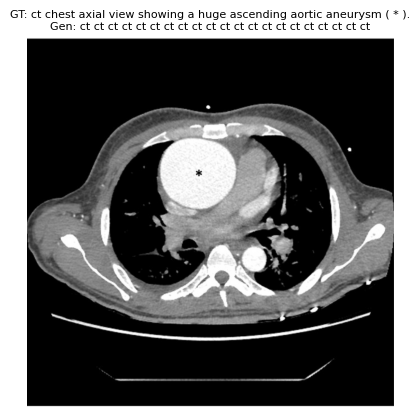

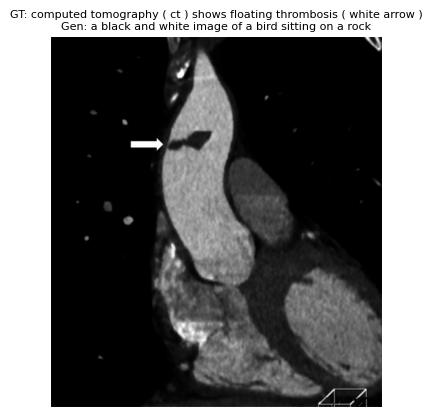

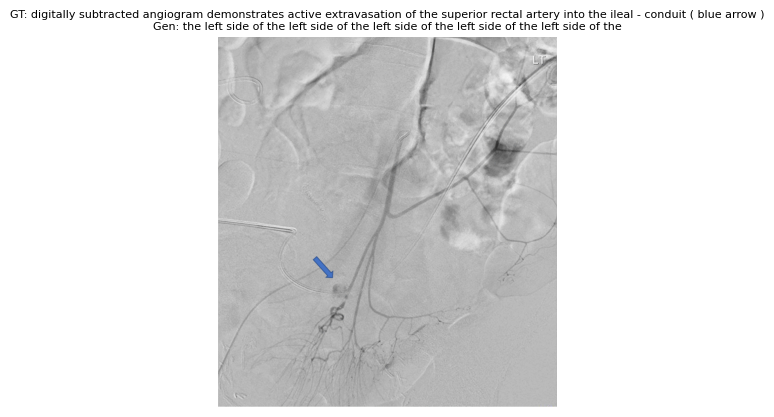

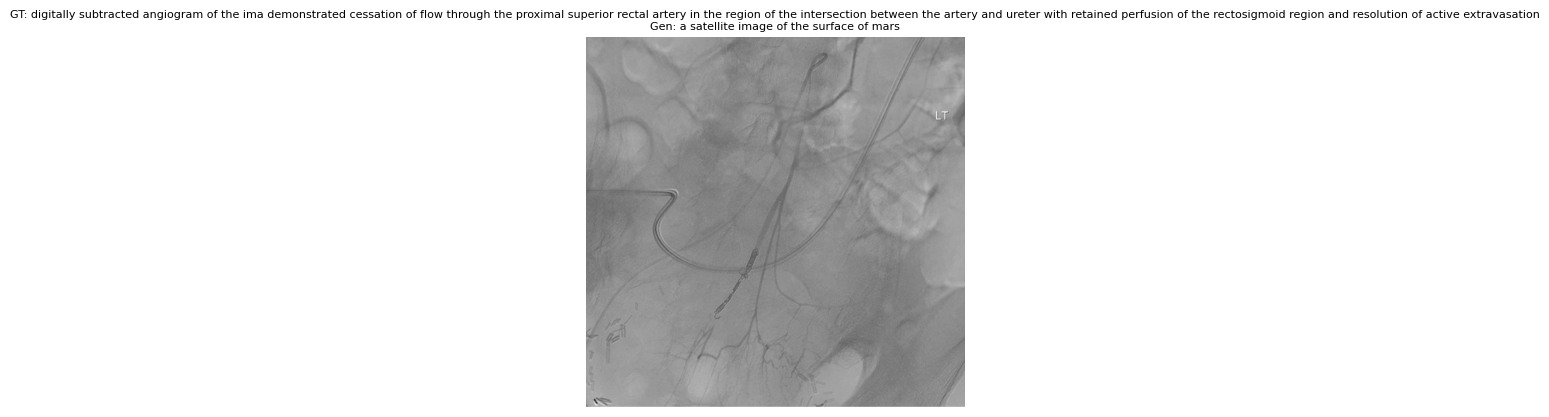

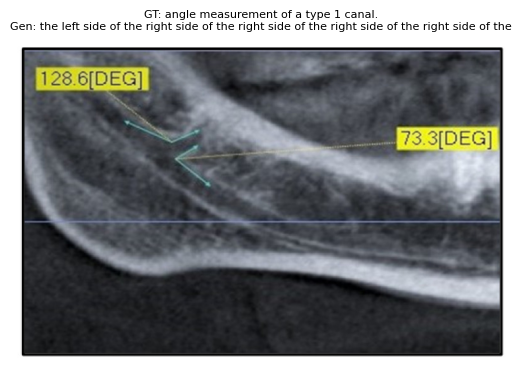

In [9]:
import matplotlib.pyplot as plt
num_examples_to_show=5
# Show a few test images with captions
for i in range(num_examples_to_show):
    image_path = dataset_test.image_list[i]
    image = Image.open(image_path).convert("RGB")

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"GT: {gt_captions_text[i]}\nGen: {generated_captions[i]}", fontsize=8)
    plt.show()
